In [1]:
# %load 01_calc_correlations.py

import pandas as pd
from correlation_analysis.calc_correlations import init, get_corr, build_network
import numpy as np
import networkx as nx
from networkx import algorithms
import matplotlib.pyplot as plt

''' Load MTDB database'''
# mtbd_version = '4.4.4'
mtbd_version = '5.2.1'
db_file = 'mtdb/MasterDatabase_v%s.xlsx'%(mtbd_version)
init(db_file)
''' END '''


data = pd.read_csv('Gulf_war_updated_20181023.csv')
method='pearson'
threshMin = 0.7
threshMax = 0.95
threshInc = 0.05

In [2]:
index = np.arange(threshMin, threshMax+threshInc/2, threshInc)
print(index)

def fillData(group, filename):
    betweenness = []
    degree = []
    eigenvector = []
    load = []
    for i in np.nditer(index):
        network = get_corr(data, group, method, threshold=i) # returns a dataframe with all pairwise correlations (above the r value threshold)
        numNodes = len(network)
        type='all'
        G = build_network(network, filename=filename, type=type) # this returns a networkX graph
        betweenness.append(sum(algorithms.betweenness_centrality(G).values(), 0.0) / float(numNodes))
        degree.append(sum(algorithms.degree_centrality(G).values(), 0.0) / float(numNodes))
        eigenvector.append(sum(nx.eigenvector_centrality_numpy(G).values(), 0.0) / float(numNodes))
        load.append(sum(algorithms.load_centrality(G).values(), 0.0) / float(numNodes))
    df = pd.DataFrame({'betweenness': betweenness,
                       'degree': degree,
                       'eigenvector': eigenvector,
                       'load': load})
    df = df.set_index(index)
    return df

# Build correlation network from control data
control = fillData('Control','control.json')
print(control)

# build correlation network from case data ("GWS")
case = fillData('GWS', 'case.json')
print(case)

[0.7  0.75 0.8  0.85 0.9  0.95]
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
top corr ('15-HETE', '11-HETE')
top anticorr ('L-Lysine', 'Arachidonic Acid')
      betweenness    degree  eigenvector      load
0.70     0.002417  0.003215     0.002679  0.002417
0.75     0.000529  0.003534     0.003709  0.000529
0.80     0.000119  0.004484     0.004661  0.000119
0.85     0.000074  0.005618     0.007206  0.000074
0.90     0.000055  0.008000     0.012293  0.000055
0.95     0.000100  0.018519     0.030843  0.000100
top corr ('5-HETE', '11-HETE')
top anticorr ('L-Lysine', 'L-Homoserine')
top corr ('5-HETE', '11-HETE')
top anticorr ('L-Lysine', 'L-Homoserine

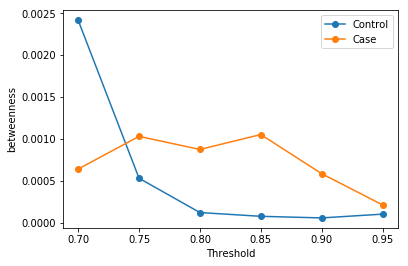

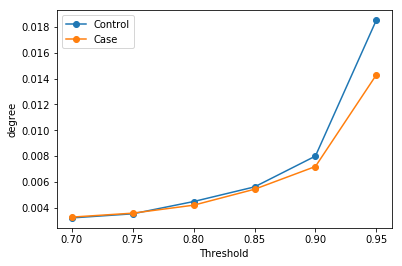

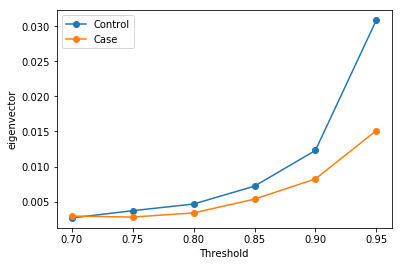

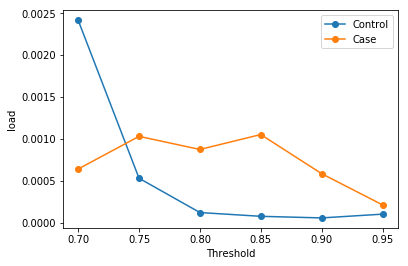

In [3]:
for i in list(control):
    f, ax = plt.subplots()
    ax.plot(index, control[i], 'o-', label='Control')
    ax.plot(index, case[i], 'o-', label='Case')
    ax.legend(loc='best')
    plt.xlabel('Threshold')
    plt.ylabel(i)

In [14]:
data = pd.read_excel('GWI_GWS_pearson_VR_Data_v2.xlsx', sheet_name = 'Sheet1')
def reduceData(thresholdR):
    df = data[(data['FDR'] < 0.05) & (data['abs(r)'] > thresholdR)]
    df = pd.concat([df[['x1','y1', method + ' r']].copy(),
                    df[['x2','y2', method + ' r']].copy().rename(columns={'x2':'x1', 'y2':'y1'})])
    pos = df[df[method + ' r'] > 0]
    neg = df[df[method + ' r'] < 0]
    pos = pos.groupby(['x1', 'y1']).sum().reset_index()
    neg = neg.groupby(['x1', 'y1']).sum().reset_index()
    return pos, neg

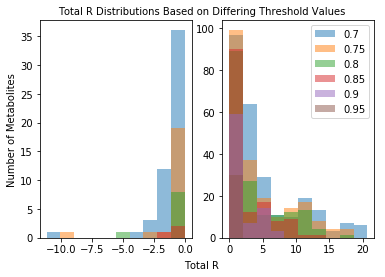

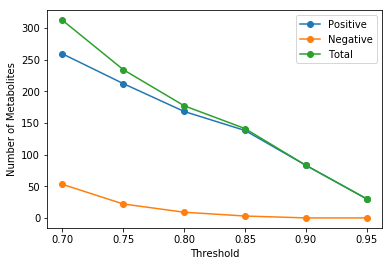

In [18]:
posLen = []
negLen = []
minTotal = maxTotal = 0
f, ax = plt.subplots(nrows=1, ncols=2)
for i in np.nditer(index):
    pos, neg = reduceData(i)
    posLen.append(len(pos))
    negLen.append(len(neg))
    if (i == index.flat[0]):
        maxTotal = max(pos[method + ' r'])
        minTotal = min(neg[method + ' r'])
    ax[0].hist(neg[method + ' r'], bins=10, range=(minTotal, 0), alpha=0.5, label=np.round(i,2))
    ax[1].hist(pos[method + ' r'], bins=10, range=(0, maxTotal), alpha=0.5, label=np.round(i,2))
f.text(0.5, 0.02, 'Total R', ha='center')
f.text(0.05, 0.5, 'Number of Metabolites', va='center', rotation='vertical')
f.text(0.5, 0.9, 'Total R Distributions Based on Differing Threshold Values', ha='center')
plt.legend(loc='best')
plt.show()

f, ax = plt.subplots()
ax.plot(index, posLen, 'o-', label='Positive')
ax.plot(index, negLen, 'o-', label='Negative')
ax.plot(index, [x + y for x, y in zip(posLen, negLen)], 'o-', label='Total')
ax.legend(loc='best')
plt.xlabel('Threshold')
plt.ylabel('Number of Metabolites')
plt.show()

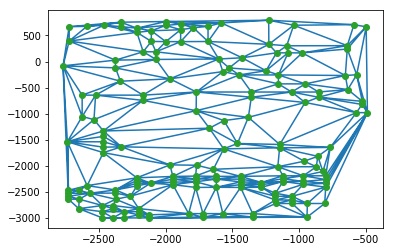

In [49]:
from scipy.spatial import Delaunay
from shapely.geometry.polygon import Polygon

pos, neg = reduceData(0.8)
posPoints = np.zeros(shape=(len(pos),2))
numPosPoints = len(posPoints)
for index, row in pos.iterrows():
    posPoints[index] = [row['x1'], row['y1']]
tri = Delaunay(posPoints)
triSimplices = tri.simplices

# Create dictionary of point indicies to eventual polygon indices
indices = {}
for i in range(len(triSimplices)):
    for j in range(3):
        pointIndex = triSimplices[i][j]
        if pointIndex in indices:
            indices[pointIndex].append(i)
        else:
            indices[pointIndex] = [i]
plt.triplot(posPoints[:,0], posPoints[:,1], tri.simplices)
plt.plot(posPoints[:,0], posPoints[:,1], 'o')
plt.show()

def unconnectedPoints(simplices, numPoints):
    fullList = range(numPoints)
    listIndices = set()
    for i in range(len(simplices)):
        for j in range(3):
            listIndices.add(simplices[i][j])
    return list(listIndices ^ set(fullList))

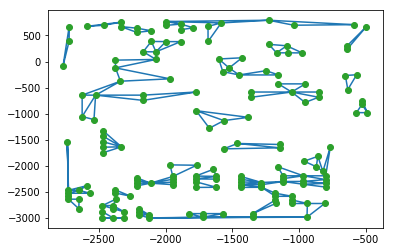

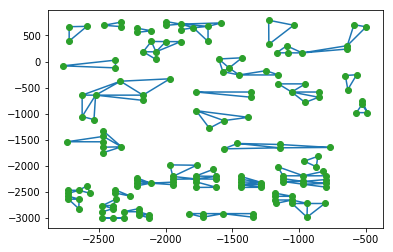

166


In [55]:
import heapq as hq

# Minimize area
coord_groups = [tri.points[x] for x in tri.simplices]
polygons = [Polygon(x) for x in coord_groups]

def smallestPolyArea(pointIndex):
    polyInd = indices[pointIndex]
    h = []
    for i in polyInd:
        hq.heappush(h, (polygons[i].area, i))
    return hq.heappop(h)[1]

def smallestPolyLen(pointIndex):
    polyInd = indices[pointIndex]
    h = []
    for i in polyInd:
        hq.heappush(h, (polygons[i].length, i))
    return hq.heappop(h)[1]

# Minimize area
areaSimplices = []
for i in range(numPosPoints):
    if i in unconnectedPoints(areaSimplices, numPosPoints):
        areaSimplices.append(triSimplices[smallestPolyArea(i)])
plt.triplot(posPoints[:,0], posPoints[:,1], areaSimplices)
plt.plot(posPoints[:,0], posPoints[:,1], 'o')
plt.show()

# Minimize circumference
lenSimplices = []
for i in range(numPosPoints):
    if i in unconnectedPoints(lenSimplices, numPosPoints):
        lenSimplices.append(triSimplices[smallestPolyLen(i)])
plt.triplot(posPoints[:,0], posPoints[:,1], lenSimplices)
plt.plot(posPoints[:,0], posPoints[:,1], 'o')
plt.show()

print(tri.simplices[0][0])

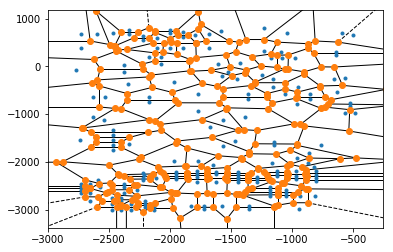

In [41]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(posPoints)
fig = voronoi_plot_2d(vor)
plt.show()